# Explaining Image Captioning (Image to Text) using Azure Cognitive Services and Partition Explainer

This notebook demonstrates how to use SHAP for explaining output of image captioning models i.e. given an image, model outputs a caption for the image. 

Here, we are **using Azure Cognitive Services Computer Vision (COGS CV) Image Understanding (Analyze Image) feature https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/#features to get image captions.** 

In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import requests
import shap
from shap.utils.image import *
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

### API Details

**To use Azure COGS CV and run this notebook, please get the API Key and Endpoint specific to your subscription of Azure COGS CV and replace in code below <>**. It is recommended to get the paid service instead of the free service in order to not be rate limited for the API calls and get explanations quickly. 

In [2]:
# place your Azure COGS CV subscription API Key and Endpoint below
API_KEY = "<your COGS API access key>"
ENDPOINT = "<endpoint specific to your subscription>"

ANALYZE_URL = ENDPOINT + "/vision/v3.1/analyze"

In [3]:
def get_caption(path_to_image):
    
    """
    Function to get image caption when path to image file is given. 
    Note: API_KEY and ANALYZE_URL need to be defined before calling this function.
    
    Parameters
    ----------
    path_to_image   : path of image file to be analyzed
    
    Output
    -------
    image caption
    """

    headers  = {
        'Ocp-Apim-Subscription-Key': API_KEY,
        'Content-Type': 'application/octet-stream'
    }
    params   = {
        'visualFeatures': 'Description',
        'language': 'en',
    }
    
    payload = open(path_to_image, 'rb').read()
    
    # get image caption using requests
    response = requests.post(ANALYZE_URL, headers=headers, params=params, data=payload)
    results = json.loads(response.content)
    
    # return the first caption's text in results description 
    caption = results['description']['captions'][0]['text'] 
    
    return caption

### Load Data

1. To get explanations for image captions, place images to be explained in a folder called 'test_images' in the current notebook working directory. 

2. Azure COGS CV accepts images of the following file formats: JPEG (JPG), PNG, GIF, BMP, JFIF

3. Azure COGS CV has size limit of < 4MB and min size of 50x50 for images. Hence, large image files are being reshaped in code below to increase speed of SHAP explanations and run Azure COGS for image captions. If image (pixel_size, pixel_size) is greater than 500 for either of the dimensions, image is resized to have max. 500 pixel size for each dimension. 
    
    **Note**: Reshaped image caption may be different from the original image caption. If explanation for the original image is needed, please toggle the 'reshape' variable below to 'False'. However, please note this might slow down the explanation process significantly or cause Azure COGS CV to not generate a caption (SHAP will not be able to generate explanation for this image.) 

In [4]:
# directory of images to be explained
DIR = './test_images/' 

# directory for saving resized images
DIR_RESHAPED = os.path.join(DIR, "reshaped_images/") 
make_dir(DIR_RESHAPED) # creates or empties directory if it already exists

# directory for saving masked images
DIR_MASKED = os.path.join(DIR, "masked_images/") 
make_dir(DIR_MASKED) 

# check if 'test_images' folder exists and if it has any files
if not is_empty(DIR):

    X = []
    reshape = True
    files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, f))]
    
    for file in files:
        
        path_to_image = os.path.join(DIR, file)
        
        # check if file has of any of the following acceptable extensions: JPEG (JPG), PNG, GIF, BMP, JFIF
        if check_valid_image(file): 
            print("\nLoading image:", file)
            print("Image caption:", get_caption(path_to_image))
            image = load_image(path_to_image)
            print("Image size:", image.shape)

            # reshaping large image files
            if reshape:
                image, reshaped_file = resize_image(path_to_image, DIR_RESHAPED)
                if reshaped_file:   
                    print("Reshaped image caption:", get_caption(reshaped_file, API_KEY, ANALYZE_URL))
            
            X.append(image)
        else:
            print("\nSkipping image due to invalid file extension:", file)
    
    print("\nNumber of images in test dataset:", len(X))


Loading image: 25.jpg
Image caption: a woman sitting on a rock
Image size: (480, 480, 3)

Loading image: 26.png
Image caption: a bird on a branch
Image size: (224, 224, 3)

Loading image: 30.jpg
Image caption: a couple of horses standing on grass
Image size: (224, 224, 3)

Loading image: 44.jpg
Image caption: a basketball player in a white jersey
Image size: (500, 500, 3)

Number of images in test dataset: 4


### Load language model and tokenizer

Transformer Language Model 'distilbart' and tokenizer are being used here to tokenize the image caption. This makes the image to text scenario similar to a multi-class problem. 'distilbart' is used to do alignment scoring between the original image caption and masked image captions being generated i.e. how does the probability of getting the original image caption change when the context of a masked image caption is given? (a.k.a. we are teacher forcing 'distilbart' to always produce the original image caption for the masked images and getting change in logits for each tokenized word in the caption as part of the process).

**Note**: We are using 'distilbart' here because during experimentation process we found it to give the most meaningful explanations for images. We have compared with other language models such as 'openaigpt' and 'distilgpt2'. Please feel free to explore with other language models of your choice and compare the results. 

In [5]:
# load transformer language model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

### Create an explainer object using wrapped model and image masker

Various options for explainer object to experiment with:

1. **mask_value**      : Image masker uses an inpainting technique by default for masking (i.e. mask_value = "inpaint_ns"). There are alternate masking options available for blurring/inpainting  such as "inpaint_telea" and "blur(kernel_xsize, kernel_xsize)". Note: Different explanations can be generated by different masking options.

2. **max_evals**       : Number of evaluations done of the underlying model to get SHAP values. Recommended number of evaluations is 300-500 to get explanations with meaningful granularity of super pixels. More the number of evaluations, more the granularity but also increases run-time. Default is set to 300 evals. 

3. **batch_size**      : Number of masked images to be evaluated at once. Default size is set to 50. 

4. **fixed_context**   : Masking technqiue used to build partition tree with options of '0', '1' or 'None'. 'fixed_context = None' is the best option to generate meaningful results but it is relatively slower than fixed_context = 0 or 1 because it generates a full partition tree. Default option is set to 'None'. 

In [8]:
# setting values for logging/tracking variables
make_dir(DIR_MASKED)
image_counter = 0 
mask_counter = 0 
masked_captions = defaultdict(list)
masked_files = defaultdict(list)


# define function f which takes input (masked image) and returns caption for it 
def f(x): 
    """"
    Function to return caption for masked image(x).
    """
    global mask_counter

    # saving masked array of RGB values as an image in masked_images directory
    path_to_image = os.path.join(DIR_MASKED, "{0}_{1}.png".format(image_counter, mask_counter))
    save_image(x, path_to_image) 
    
    # get caption for masked image
    caption = get_caption(path_to_image)
    masked_captions[image_counter].append(caption)
    masked_files[image_counter].append(path_to_image)
    mask_counter += 1 
    
    return caption

# function to take a list of images and parameters such as masking option, max evals etc. and generate shap values
def run_masker(X, mask_value = "inpaint_ns", max_evals = 300, batch_size = 50, fixed_context = None, show_grid_plot = False, limit_grid = 20):
    """
    Function to take a list of images and parameters such max evals etc. and generate shap explanations for test images(X). 
    Paramaters
    ----------
    X               : list of images which need to be explained
    mask_value      : various masking options for blurring/inpainting such as "inpaint_ns", "inpaint_telea" and "blur(pixel_size, pixel_size)"
    max_evals       : number of evaluations done of the underlying model to get SHAP values 
    batch_size      : number of masked images to be evaluated at once 
    fixed_context   : masking technqiue used to build partition tree with options of '0', '1' or 'None'
    show_grid_plot  : if set to True, shows grid plot of all masked images and their captions used to generate SHAP values (default set to False)
    limit_grid      : limit number of masked images shown (default set to 20). Change to "all" to show all masked_images.
    """
    global image_counter
    global mask_counter

    for index in range(len(X)): 

        # define a masker that is used to mask out partitions of the input image based on mask_value option
        masker = shap.maskers.Image(mask_value, X[index].shape)

        # wrap model with TeacherForcingLogits class
        wrapped_model = shap.models.TeacherForcingLogits(f, similarity_model=model, similarity_tokenizer=tokenizer)

        # build a partition explainer with wrapped_model and image masker
        explainer = shap.Explainer(wrapped_model, masker) 

        # compute SHAP values - here we use max_evals no. of evaluations of the underlying model to estimate SHAP values
        shap_values = explainer(np.array(X[index:index+1]), max_evals = max_evals, batch_size = batch_size, fixed_context = fixed_context)

        # output plot
        shap_values.output_names[0] = [word.replace('Ġ', '') for word in shap_values.output_names[0]] 
        shap.image_plot(shap_values)

        # show grid plot of masked images and their captions 
        if show_grid_plot:
            if limit_grid == "all":
                display_grid_plot(masked_captions[image_counter], masked_files[image_counter])
            elif isinstance(limit_grid,int) and limit_grid < len(masked_captions[image_counter]):
                display_grid_plot(masked_captions[image_counter][0:limit_grid], masked_files[image_counter][0:limit_grid])
            else:
                print("Enter a valid number for limit_grid parameter.")

        # setting values for next iterations
        mask_counter = 0
        image_counter += 1

### SHAP explanation for test images

Partition explainer: 2it [05:41, 170.83s/it]              


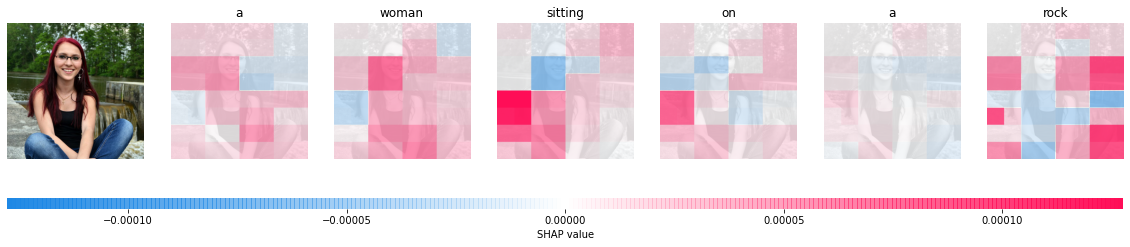

Partition explainer: 2it [03:22, 101.40s/it]              


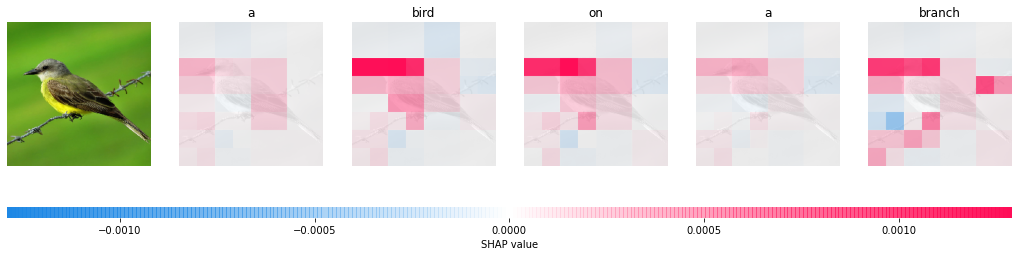

Partition explainer: 2it [03:31, 105.61s/it]              


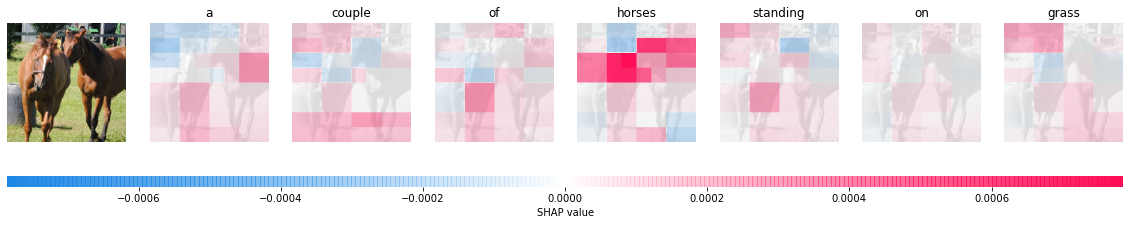

Partition explainer: 2it [06:11, 185.96s/it]              


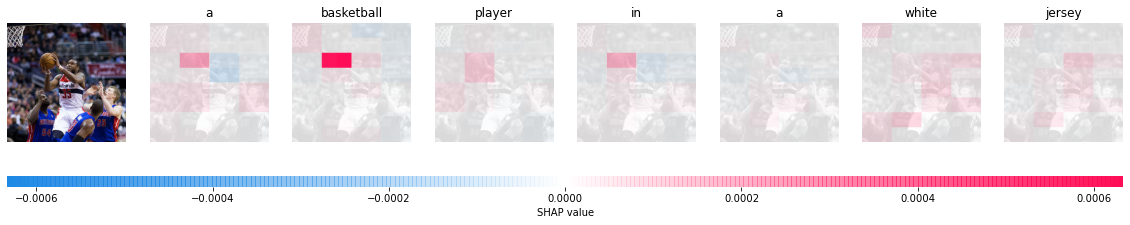

In [7]:
# run masker with test images dataset (X) and get SHAP explanations for their captions
run_masker(X)

Partition explainer: 2it [04:06, 123.14s/it]              


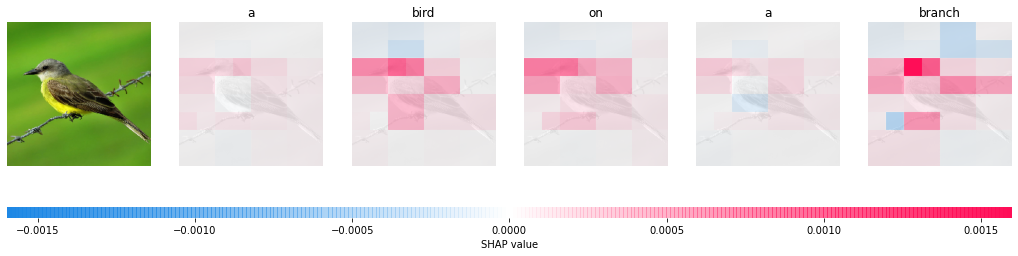

Partition explainer: 2it [03:57, 118.91s/it]              


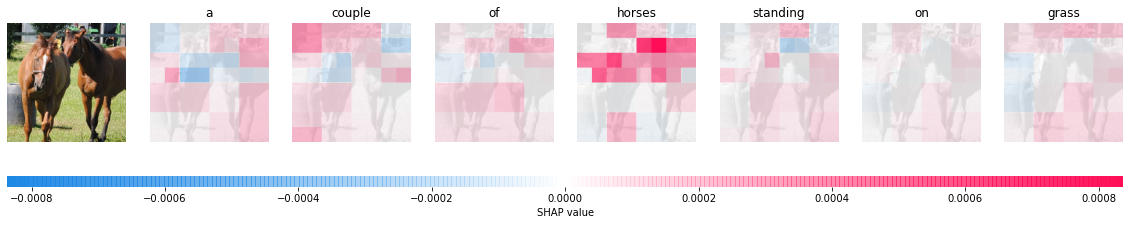

Partition explainer: 2it [07:27, 223.74s/it]              


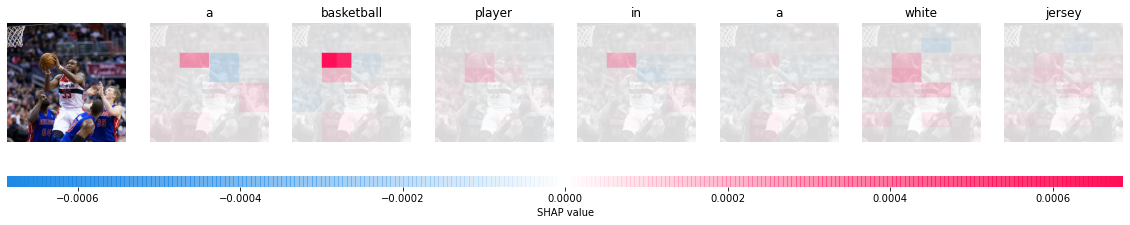

In [8]:
# SHAP explanation using alternate masking option for inpainting ("inpaint_telea") 
run_masker(X[1:4],  mask_value = "inpaint_telea")

Partition explainer: 2it [06:59, 209.88s/it]              


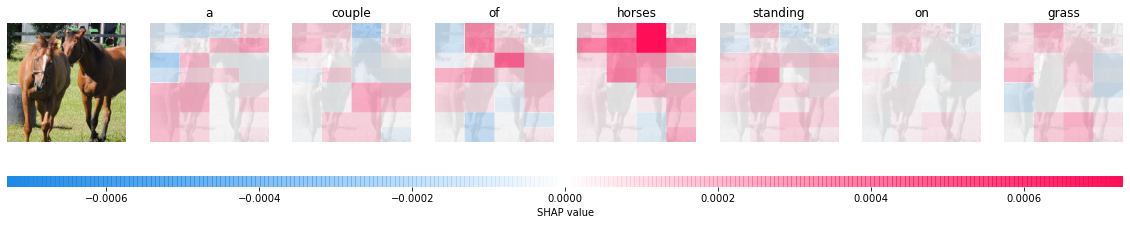

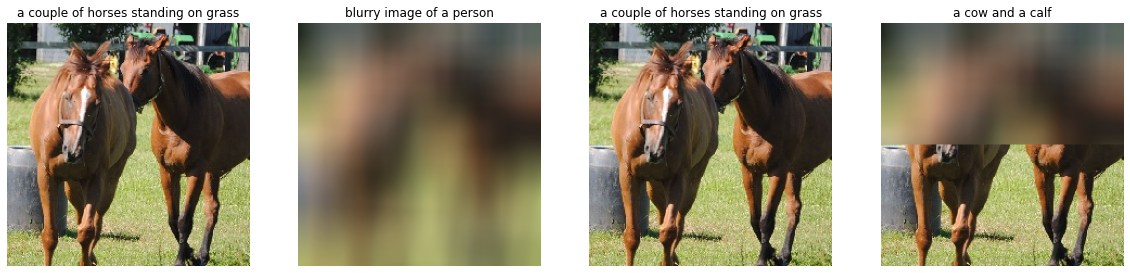

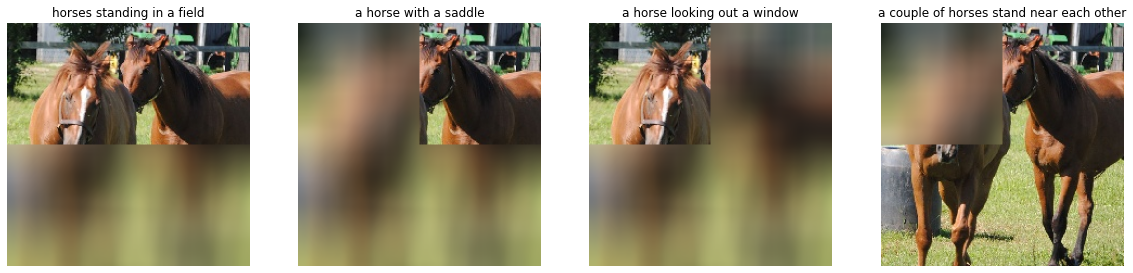

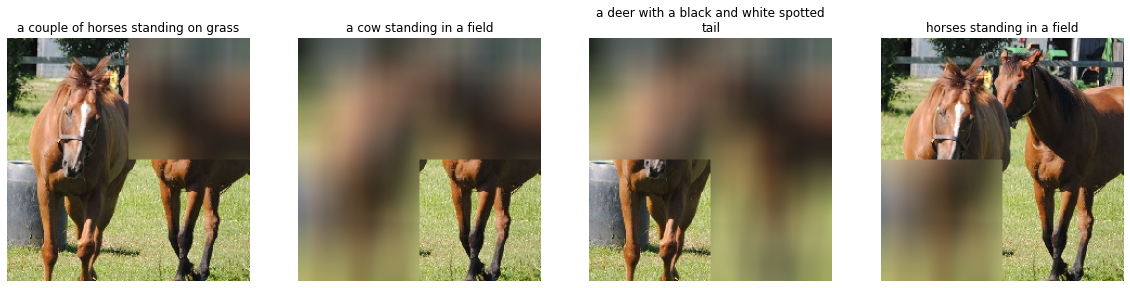

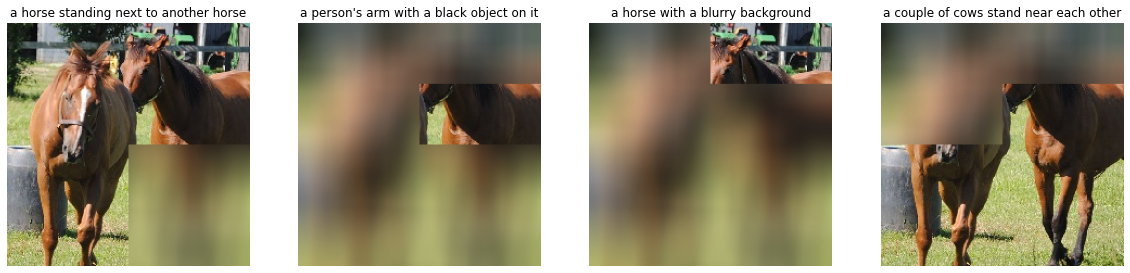

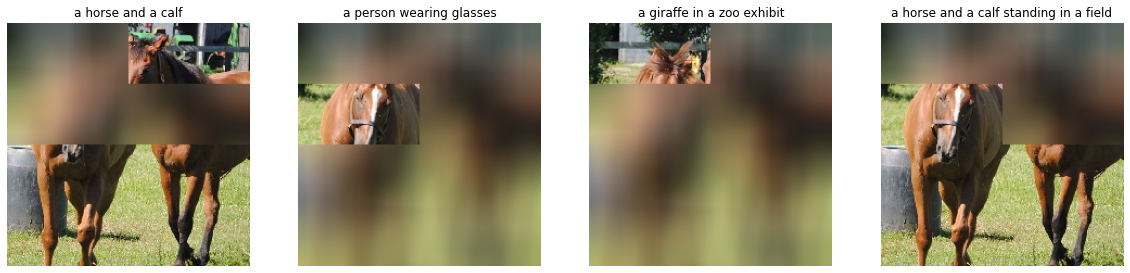

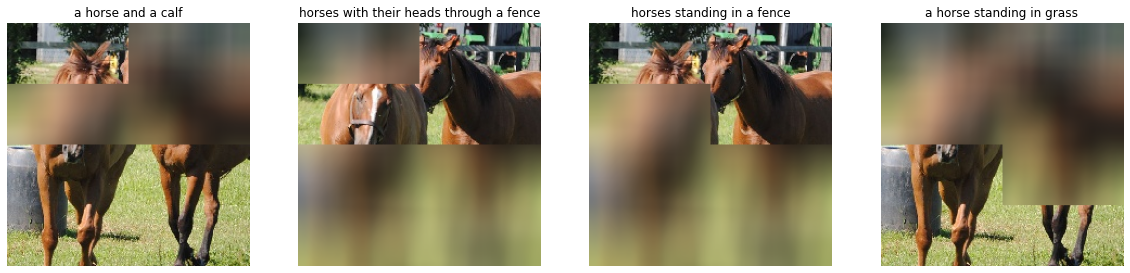

In [10]:
# SHAP explanation using alternate masking option for blurring "blur(pixel_size, pixel_size)"
# display grid plot of masked images and their captions
# change limit_grid = "all" to show all masked images instead of limiting to 24 masked images 
run_masker(X[2:3],  mask_value = "blur(56,56)", show_grid_plot= True, limit_grid = 24)